In [258]:
%matplotlib notebook
import numpy as np
import scipy.io as scio
import math as mt
import sys
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy as sc
#import seaborn as sns
import pylab
#from sklearn import linear_model

In [5]:
## Set de datos de bicicleta eléctrica ##
#mat = scio.loadmat('bicycleData.mat')
#dataset = 'sim11'
database = 'bicicleta5.mat'
mat = scio.loadmat(database)
dataset = 'bicicleta'
print(np.shape(mat[dataset]))
if database == 'bicicleta.mat':
    simLength = len(mat[dataset][145:7814,0])
if database == 'bicicleta5.mat':
    simLength = len(mat[dataset][:,0])
print("Largo de serie de datos")
print(simLength)
sampleRes = 1
t = np.arange(0,simLength/sampleRes,1/sampleRes)
## Porcentaje de datos a mostrar el error ##
desiredPercent = 0.8
percentError = 1-desiredPercent

### Datos serie bicicleta ###
if database == 'bicicleta.mat':
    x = mat[dataset][145:7814,0]
    y = mat[dataset][145:7814,1]
    z = mat[dataset][145:7814,2]
if database == 'bicicleta5.mat':
    x = mat[dataset][:,0]
    y = mat[dataset][:,1]
    z = mat[dataset][:,2]
    a = mat[dataset][:,3]

x=x-np.mean(x); x=x/np.std(x)
y=y-np.mean(y); y=y/np.std(y)
z=z-np.mean(z); z=z/np.std(z)
if database == 'bicicleta3.mat':
    a=a-np.mean(a); a=a/np.std(a)

#signal = [x,y,z]#,a]
if database == 'bicicleta.mat':
    signal = [x,y]
if database == 'bicicleta5.mat':
    signal = [x,y,a]
signal = np.array(signal)

devChannel = np.sqrt(0.7)
std_1 = devChannel
std_2 = devChannel
std_3 = devChannel

r1 = np.random.normal(0,std_1**2,len(t))
r2 = np.random.normal(0,std_2**2,len(t))
r3 = np.random.normal(0,std_3**2,len(t))

x_noise = x #+ r1
y_noise = y #+ r2
z_noise = z #+ r3
if database == 'bicicleta5.mat':
    a_noise = a
print(np.shape(signal))

(7669, 4)
Largo de serie de datos
7669
(3, 7669)


<IPython.core.display.Javascript object>


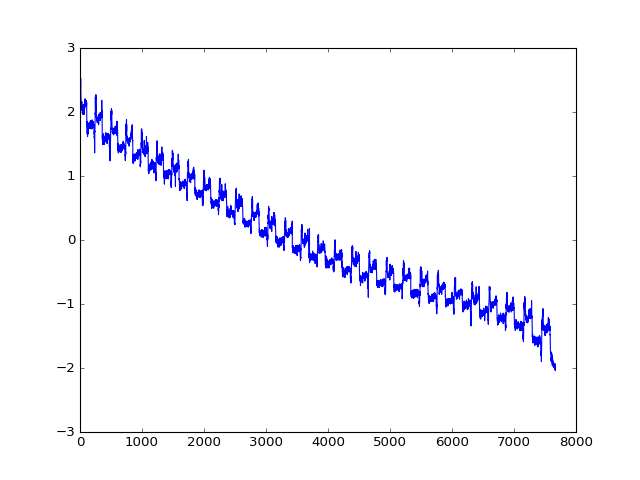

In [6]:
plt.plot(y)
plt.show()

In [7]:
# en esta celda es solo inicialización: 
# se importan paquetes a utilizar y se definen funciones que serán requeridas más tarde. 
# Ver comentarios en cada unas de las funciones.


#esta línea indica que las figuras se muestran en el notebook
%matplotlib inline 

import numpy as np
from numpy import *
import scipy
from scipy.optimize import fmin_l_bfgs_b as fmin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#import seaborn as sns #- uncomment this if you want to use seaborn for better-looking plots
import os
import time


def SE(a,b,gamma=1./2,sigma=1): 
	#Square Exponential kernel

	#returns the evaluation of the kernel
	#k(a,b)=sigma**2*exp(-gamma*(a-b)**2), 
	#notice that in this definition gamma = 1 /(2*lengthscale**2), in order to simplify the derivatives
	#for consistency with the generation of Gram matrices, this function returns
	#a matrix of dimensions dim(a) x dim(b);  
  
	#INPUTS
	#a,b are column vectors of (possibly) different lenghts
	sa=np.size(a); sb=np.size(b)

	if sa==1: a=np.array([a])
	if sb==1: b=np.array([b])
	K=np.zeros([sa,sb])
	#accelerate computation if a==b
	if np.array_equal(a,b):
		for va in range(sa):
			K[va,va]=1;
			for vb in range(va+1,sb):
				K[va,vb]=exp(-(a[va]-b[vb])**2*gamma)
				K[vb,va]=K[va,vb]
	#a!=b
	else:
		for va in range(sa):
			for vb in range(sb):
				K[va,vb]=exp(-(a[va]-b[vb])**2*gamma);
	if sa==1:
		return sigma**2*np.reshape(K,b.shape)
	elif sb==1:
		return sigma**2*np.reshape(K,a.shape)
	else:
		return sigma**2*K

#negative log-likelihood when using SE kernel
def like_SE(X, y, t): 

    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_noise, gamma_1, sig_1 = np.exp(X)     
	Gram=SE(t,t,gamma=gamma_1,sigma=sig_1)+sigma_noise**2*np.identity(len(t))
	print(np.all(Gram>0))
	print(np.min(Gram))
	print(np.shape(Gram))
	print(Gram[:3,:3])
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using SE kernel
def like_SE_Df(X, y, t):
	sigma_noise, gamma_1, sig_1 = np.exp(X)
	Gram0=SE(t,t,gamma=gamma_1,sigma=sig_1)
	Gram=Gram0+sigma_noise**2*np.identity(len(t))
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	A=np.dot(invGram,y)
	outer_sub=outersum(t,-t)
	D1=2*sigma_noise**2*np.identity(len(t)) #sigma_noise
	D2=-Gram0*outer_sub**2*gamma_1 #gamma_1
	D3=2*Gram0 #sig_1 

	B=np.outer(A,A)-invGram
	d1=  -np.trace(np.dot(B,D1))
	d2=  -np.trace(np.dot(B,D2))
	d3=  -np.trace(np.dot(B,D3))
   	#print(['Derivatives: ', d1, d2, d3])
	return np.asarray([0.5*d1, 0.5*d2, 0.5*d3])
    
# "suma" externa
def outersum(a,b):
	return np.outer(a,ones_like(b))+np.outer(ones_like(a),b)

In [8]:
# Esta celda lee datos del archivo hr2.txt, los que corresponden a una señal de frecuencia cardíaca.
# Luego, se elige un subconjunto de los valores de la señal que representa las observaciones disponibles
# la señal completa es graficada en negro y las observaciones en rojo

#hr=[] #init array
#for line in open('hr2.txt', 'r'): #abre archivo
#	item = line.rstrip() 	# lee línea
#	hr.append(float(item)) #convierte a float
y=np.asarray(y); y=y-mean(y); y=y/std(y)  # convierte a array y normaliza (opcional)
f=y #señal es igual a versión ruidosa
N=len(y); T0=0; TF=N # inicio, fin y tamaño
t=np.arange(N) #vector de tiempo

#elección (aleatoria)del 15% de las muestras 
i_obs=np.random.choice(arange(0,N,1),0.15*N,replace=False)
N_obs=len(i_obs)
t_obs=t[i_obs]
y_obs=y[i_obs]#; y_obs.reshape(N_obs,1)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


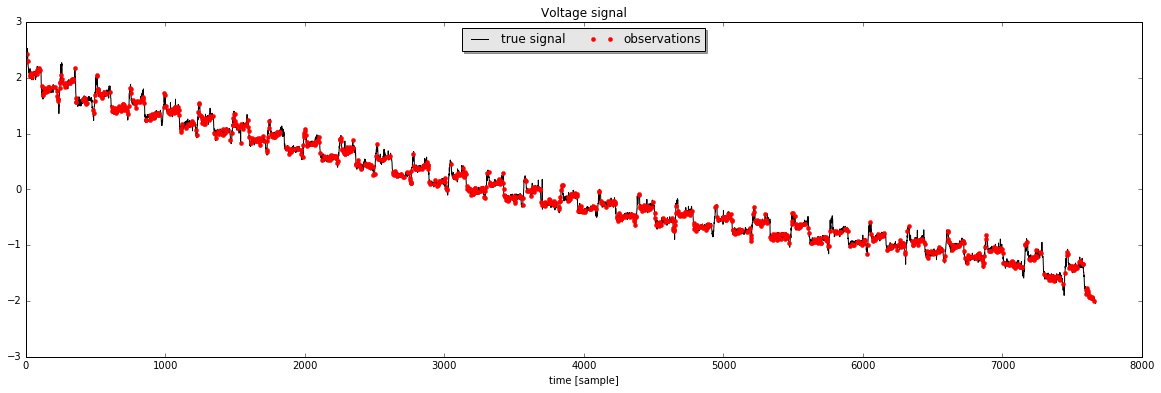

In [9]:
#gráfico
fig=plt.figure(1, figsize=(20,6))
ax = plt.gca()
plt.plot(t,f, color='black',ls='-',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Voltage signal')
plt.show()

In [11]:
#elegir hiperparámetros
sigma_y_GP_test = 0.2
gamma_test = 0.01
sigma_test= 0.5

#NLL para la elección de hiperparámetros 
print(like_SE([sigma_y_GP_test, gamma_test, sigma_test], y_obs, t_obs))


cov=SE(t,t,gamma=gamma_test,sigma=sigma_test)
cov_obs=SE(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test)
K_star=SE(t,t_obs,gamma=gamma_test,sigma=sigma_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

False
0.0
(1150, 1150)
[[ 4.21010653  0.          0.        ]
 [ 0.          4.21010653  0.        ]
 [ 0.          0.          4.21010653]]
2007.27080084


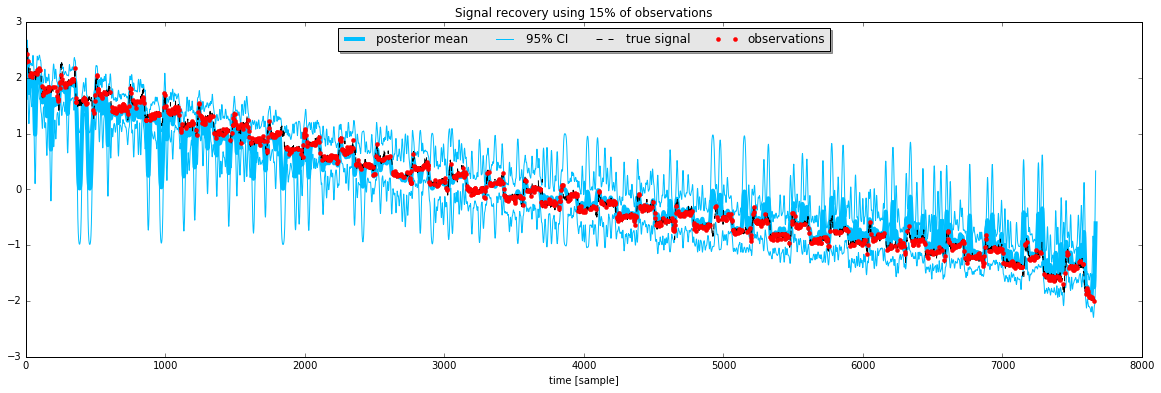

In [12]:
#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE.eps",format='eps', dpi=1000)

In [13]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_SE=0
params0=np.asarray([sigma_y_GP_test,  gamma_test,  sigma_test])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
X_opt, f_GP, data=fmin(like_SE,X0,like_SE_Df, args,disp=1,factr=0.00000001/(2.22E-12),maxiter=50)
time_GP=time.time()-time_GP
time_SE = time_GP
sigma_y_GP, gamma_1, sig_1 = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt), 'NLL: ', f_GP)
print('Tiempo transcurrido %f' %time_SE)

('Condicion inicial optimizador: ', array([ 0.2 ,  0.01,  0.5 ]))
False
0.0
(1150, 1150)
[[ 0.29  0.    0.  ]
 [ 0.    0.29  0.  ]
 [ 0.    0.    0.29]]
False
0.0
(1150, 1150)
[[ 1.23608713  0.          0.        ]
 [ 0.          1.23608713  0.        ]
 [ 0.          0.          1.23608713]]
False
0.0
(1150, 1150)
[[ 1.17871973  0.          0.        ]
 [ 0.          1.17871973  0.        ]
 [ 0.          0.          1.17871973]]
False
0.0
(1150, 1150)
[[  9.97360656e-001   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   9.97360656e-001   2.72060613e-119]
 [  0.00000000e+000   2.72060613e-119   9.97360656e-001]]
False
0.0
(1150, 1150)
[[  1.09174321e+000   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   1.09174321e+000   8.24094199e-295]
 [  0.00000000e+000   8.24094199e-295   1.09174321e+000]]
True
9.30458392406e-109
(1150, 1150)
[[  6.93450385e-01   1.43946876e-06   7.76318151e-11]
 [  1.43946876e-06   6.93450385e-01   1.76647770e-01]
 [  7.76318151e-11   1.7664777

In [14]:
#Graficar nuevamente con los hiperparámetros encontrados mediante máxima verosimilitud
cov=SE(t,t,gamma=gamma_1,sigma=sig_1)
cov_obs=SE(t_obs,t_obs,gamma=gamma_1,sigma=sig_1)
K_star=SE(t,t_obs,gamma=gamma_1,sigma=sig_1)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

KeyboardInterrupt: 

In [ ]:
#plotear estimacion, observaciones y datos totales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE_post.eps",format='eps', dpi=1000)

# Reconstrucción usando 15% de los datos (secuencial) #

In [ ]:
# Esta celda lee datos del archivo hr2.txt, los que corresponden a una señal de frecuencia cardíaca.
# Luego, se elige un subconjunto de los valores de la señal que representa las observaciones disponibles
# la señal completa es graficada en negro y las observaciones en rojo

#hr=[] #init array
#for line in open('hr2.txt', 'r'): #abre archivo
#	item = line.rstrip() 	# lee línea
#	hr.append(float(item)) #convierte a float
#y=np.asarray(y); y=y-mean(y); y=y/std(y)  # convierte a array y normaliza (opcional)
f=y #señal es igual a versión ruidosa
N=len(y); T0=0; TF=N # inicio, fin y tamaño
t=np.arange(N) #vector de tiempo

#elección (aleatoria)del 15% de las muestras 
#i_obs=np.random.choice(arange(0,N,1),0.15*N,replace=False)
i_obs = np.arange(int(.15*N))
N_obs=len(i_obs)
t_obs=t[i_obs]
y_obs=y[i_obs]#; y_obs.reshape(N_obs,1)

#gráfico
fig=plt.figure(1, figsize=(20,6))
ax = plt.gca()
plt.plot(t,f, color='black',ls='-',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Voltage signal')
plt.show()

In [ ]:
i_obs = np.arange(int(.15*N))
print(i_obs)

In [ ]:
#elegir hiperparámetros
sigma_y_GP_test = 0.2
gamma_test = 0.01
sigma_test= 0.5

#NLL para la elección de hiperparámetros 
print(like_SE([sigma_y_GP_test, gamma_test, sigma_test], y_obs, t_obs))


cov=SE(t,t,gamma=gamma_test,sigma=sigma_test)
cov_obs=SE(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test)
K_star=SE(t,t_obs,gamma=gamma_test,sigma=sigma_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE.eps",format='eps', dpi=1000)

In [ ]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_SE=0
params0=np.asarray([sigma_y_GP_test,  gamma_test,  sigma_test])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
X_opt, f_GP, data=fmin(like_SE,X0,like_SE_Df, args,disp=1,factr=0.00000001/(2.22E-12),maxiter=50)
time_GP=time.time()-time_GP
time_SE = time_GP
sigma_y_GP, gamma_1, sig_1 = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt), 'NLL: ', f_GP)
print('Tiempo transcurrido %f' %time_SE)

In [ ]:
#Graficar nuevamente con los hiperparámetros encontrados mediante máxima verosimilitud
cov=SE(t,t,gamma=gamma_1,sigma=sig_1)
cov_obs=SE(t_obs,t_obs,gamma=gamma_1,sigma=sig_1)
K_star=SE(t,t_obs,gamma=gamma_1,sigma=sig_1)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

#plotear estimacion, observaciones y datos totales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE_post.eps",format='eps', dpi=1000)

## Ajuste de tendencia lineal ## 

In [16]:
y = y
x = t

In [17]:
sampleNum = len(y)
print(np.shape(x))
print(np.shape(y))
X1 = np.asarray([np.ones(sampleNum),x]).T
X2 = np.asarray([np.ones(sampleNum),x,x**2]).T
X3 = np.asarray([np.ones(sampleNum),x,x**2,x**3]).T
X4 = np.asarray([np.ones(sampleNum),x,x**2,x**3,x**4]).T
X5 = np.asarray([np.ones(sampleNum),x,x**2,x**3,x**4,x**5]).T

polynoms = [X1,X2,X3,X4,X5]

(7669,)
(7669,)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in power


In [19]:
ratio = 1
w = []
for i in range(5):
    upper = np.dot(y,polynoms[i])
    lower = np.dot(polynoms[i].T,polynoms[i])
    lowerConstant = ratio*np.eye(i+2)
    w.append(np.dot(np.linalg.inv(lower-lowerConstant),upper))
print("Modelos obtenidos")
print("Orden 1 %s" %w[0])
print("Orden 2 %s" %w[1])
print("Orden 3 %s" %w[2])
print("Orden 4 %s" %w[3])
print("Orden 5 %s" %w[4])

Modelos obtenidos
Orden 1 [  1.69744661e+00  -4.42677432e-04]
Orden 2 [  1.99228153e+00  -6.73317524e-04   3.00743373e-08]
Orden 3 [  2.09261690e+00  -8.30265250e-04   8.12340362e-08  -4.44731594e-12]
Orden 4 [  1.96893915e+00  -5.07914944e-04  -1.07885236e-07   3.39113677e-11
  -2.50089214e-15]
Orden 5 [  1.97237621e+00  -5.15897620e-04  -1.04825289e-07   3.38724934e-11
  -2.54421169e-15  -2.99862392e-21]


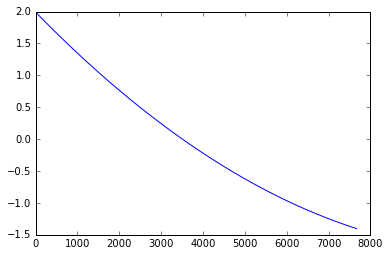

In [172]:
plt.plot(x,np.dot(polynoms[1],w[1]))
plt.show()

(7669, 1)
(7669,)


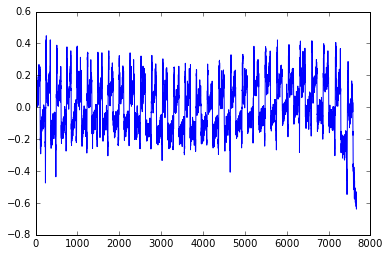

In [173]:
#regr = linear_model.LinearRegression()
t_new = t[:,np.newaxis]
print(np.shape(t_new))
print(np.shape(y))
#regr.fit(t_new, y)
y_trend = np.dot(polynoms[1],w[1])
plt.plot(y-y_trend)
plt.show()

In [23]:
print(np.mean(y-y_trend))
print(np.var(y-y_trend))

-0.000259783743675
0.0230818443359


## Ajuste de tendencia exponencial ## 

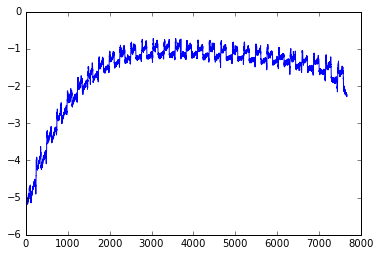

In [32]:
regr_exp = linear_model.LinearRegression()
bias = (np.min(y)-0.2)*np.ones(N)
#plt.plot(np.log(y-bias))
regr_exp.fit(t_new, np.log(y-bias))
y_trend_exp = regr_exp.predict(t_new)
plt.plot(y-bias-np.exp(y_trend_exp))
plt.show()

In [65]:
print(np.mean(y-bias-np.exp(y_trend_exp)))
print(np.var(y-bias-np.exp(y_trend_exp)))

2.03655832585e-05
0.0323001776676


In [27]:
bias = (np.min(y)-0.2)*np.zeros(N)

In [28]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [35]:
y_new = y-y_trend

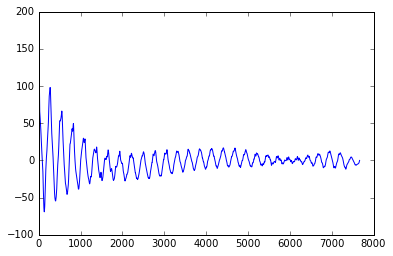

In [174]:
signal_autocorr = autocorr(y_new)
plt.plot(signal_autocorr)
plt.show()

In [222]:
#Ns = 2*.066*N
Ns = 1000
Ns = int(Ns)
Ns_p = 2
print(Ns)

1000


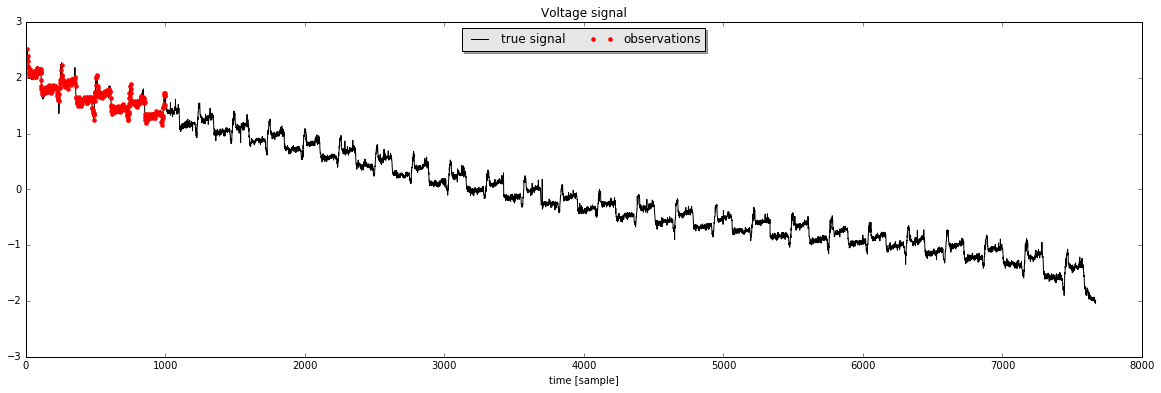

In [223]:
#elección (secuencial) del 15% de las muestras 
#i_obs=np.random.choice(arange(0,N,1),0.15*N,replace=False)
#i_obs = np.arange(int(2*.066*N))
#N_obs=len(i_obs)
#t_obs=t[i_obs]
#y_obs=y_new[i_obs]#; y_obs.reshape(N_obs,1)
#y_trend_comp = y_obs+y_trend[:len(i_obs)]

#elección (aleatoria)del 15% de las muestras 
i_obs=np.random.choice(arange(0,Ns,1),Ns/Ns_p,replace=False)
N_obs=len(i_obs)
t_obs=t[i_obs]
y_obs=y_new[i_obs]#; y_obs.reshape(N_obs,1)
y_trend_comp = y_obs+y_trend[i_obs]

#gráfico
fig=plt.figure(20, figsize=(20,6))
ax = plt.gca()
plt.plot(t,f, color='black',ls='-',label='true signal')
plt.plot(t_obs,y_trend_comp,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Voltage signal')
plt.show()

In [178]:
#elegir hiperparámetros
sigma_y_GP_test = 0.2
gamma_test = 0.01
sigma_test= 0.5

#NLL para la elección de hiperparámetros 
print(like_SE([sigma_y_GP_test, gamma_test, sigma_test], y_obs, t_obs))


cov=SE(t,t,gamma=gamma_test,sigma=sigma_test)
cov_obs=SE(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test)
K_star=SE(t,t_obs,gamma=gamma_test,sigma=sigma_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)


False
0.0
(506, 506)
[[ 4.21010653  0.          0.        ]
 [ 0.          4.21010653  0.        ]
 [ 0.          0.          4.21010653]]
822.457719347


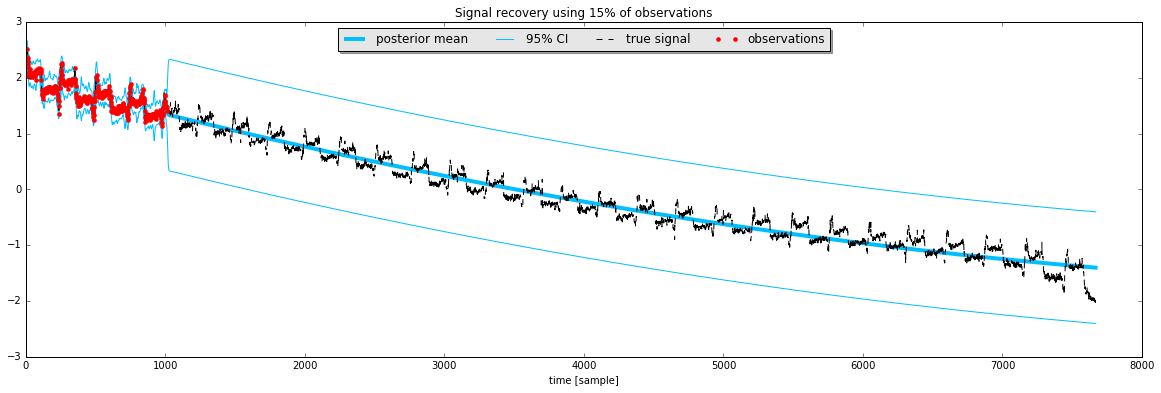

In [181]:
y_model_trend = y_model+y_trend
#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model_trend,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model_trend+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model_trend-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_trend_comp,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE.eps",format='eps', dpi=1000)

## Kernel Periodic ##

$$K_{Per}(t_1,t_2)= \sigma^2 \exp\left(-2 \gamma \sin^{2}(\pi \vert t_1-t_2 \vert p)\right)$$

$$ NLL = \frac{1}{2} y_{obs}^T  K(t_{obs},t_{obs})^{-1} y_{obs} + \frac{1}{2} \log \vert K(t_{obs},t_{obs}) \vert + \frac{N}{2} \log(2 \pi)$$

Sean $z = -2 \gamma \sin^{2}(\pi \vert t_1-t_2 \vert p^{-1})$, $q = \pi \vert t_1-t_2 \vert p^{-1}$
\begin{align}
    \frac{\partial K_{Per}(t_1,t_2)}{\partial \sigma} & = 2 \sigma \exp(z) \\
    \frac{\partial K_{Per}(t_1,t_2)}{\partial \gamma} & = -\sigma^{2} \exp(z) \frac{z}{\gamma} \\
    \frac{\partial K_{Per}(t_1,t_2)}{\partial p} & = 4\gamma\sigma^{2} \exp(z) \sin(q) \cos(q) \frac{q}{p}
\end{align}

In [25]:
r = 1

In [233]:
def Per(x, y, gamma, sigma, per):
    sx=np.size(x); sy=np.size(y)
    K = np.zeros([sx,sy])
#    print(sx)
#    print(sy)
    for i in range(sx):
        for j in range(sy):
            arg = np.sin(np.pi*np.abs(x[i]-y[j])/per)**2
            K[i,j] = np.exp(-2*gamma*(arg))
    return sigma**2*K 

def Per_diag(x, y, gamma, sigma, per):
    sx=np.size(x); sy=np.size(y)
    K = np.zeros([sx,sy])
#    print(sx)
    for i in range(sx):
        arg = np.sin(np.pi*np.abs(x[i]-y[i])/per)**2
        K[i,i] = np.exp(-2*gamma*(arg))
    return sigma**2*K 
def like_Per(X, y, t): 
    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_un, gamma_1, sigma_1, per_1 = np.exp(X)     
	Gram=Per(t,t,gamma_1,sigma_1,per_1)+sigma_un**2*np.identity(len(t));
#	check = np.linalg.eigvalsh(Gram)
#	print(np.all(check>0))
#	print(np.min(check))
#	print(np.shape(Gram))
#	print(Gram[:3,:3])
	cGg = sc.linalg.cholesky(Gram, lower=True)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	#invGram=np.linalg.inv(Gram)
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using Per kernel
def like_Per_Df(X, y, t):
	sigma_un, gamma_1, sigma_1, per_1 = np.exp(X)
	per_1 = 1/per_1    
	Gram0=Per(t,t,gamma_1,sigma_1,per_1)
	Gram=Gram0+sigma_un**2*np.identity(len(t));
	check = np.linalg.eigvalsh(Gram)
#	print(np.all(check>0))
#	print(np.min(check))
#	print(np.shape(Gram))
#	print(Gram[:3,:3])
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	#invGram = np.linalg.norm(Gram)
	A=np.dot(invGram,y)
	outer_sub=outersum(t,-t)
	q = np.pi*per_1*outer_sub
	z = -2*gamma_1*np.sin(q)
	D1= 2*sigma_un**2*np.identity(len(t)) #sigma_un
	D2= -Gram0*z/gamma_1*sigma_1**2 #gamma_1
	D3= 2*Gram0*sigma_1**2 #sigma_1
	D4= 4*Gram0*gamma_1*np.sin(q)*np.cos(q)*q/per_1*sigma_1**2 #per_1

	B=np.outer(A,A)-invGram
	d1=  -np.trace(np.dot(B,D1))
	d2=  -np.trace(np.dot(B,D2))
	d3=  -np.trace(np.dot(B,D3))
	d4=  -np.trace(np.dot(B,D3))
   	#print(['Derivatives: ', d1, d2, d3])
	return np.asarray([0.5*d1, 0.5*d2, 0.5*d3, 0.5*d4])

(1, 7669)


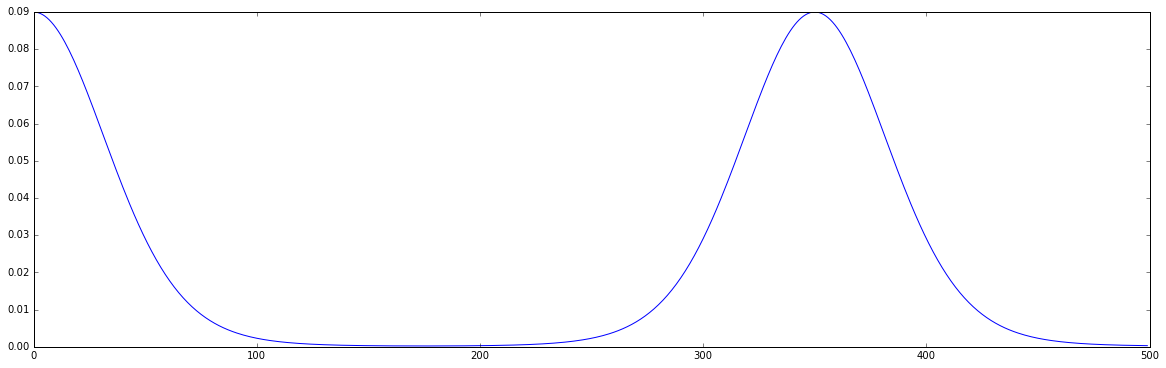

In [253]:
fig=plt.figure(10, figsize=(20,6))
#plt.plot(Per(np.array([0]),t,gamma=gamma_test,sigma=sigma_test,per=per_test))
print np.shape(Per(np.array([0]),t,gamma=gamma_test,sigma=sigma_test,per=per_test))
aux = Per(np.array([0]),t,gamma=gamma_test,sigma=sigma_test,per=per_test)
plt.plot(aux[0][:500])

In [252]:
#elegir hiperparámetros
sigma_y_GP_test = 1e1#0.2
gamma_test = 3e0#0.001
sigma_test = 0.3e0#0.5
per_test = 3.5e2#0.5


#NLL para la elección de hiperparámetros 
print(like_Per([sigma_y_GP_test, gamma_test, sigma_test, per_test], y_obs, t_obs))


cov=Per_diag(t,t,gamma=gamma_test,sigma=sigma_test,per=per_test)
cov_obs=Per(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
K_star=Per(t,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
Gram = cov_obs+sigma_y_GP_test**2*np.identity(N_obs)
#invGramg = np.linalg.inv(Gram)
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)
y_model_trend = y_model+y_trend
print("Done")

5459.46926755
Done


<IPython.core.display.Javascript object>


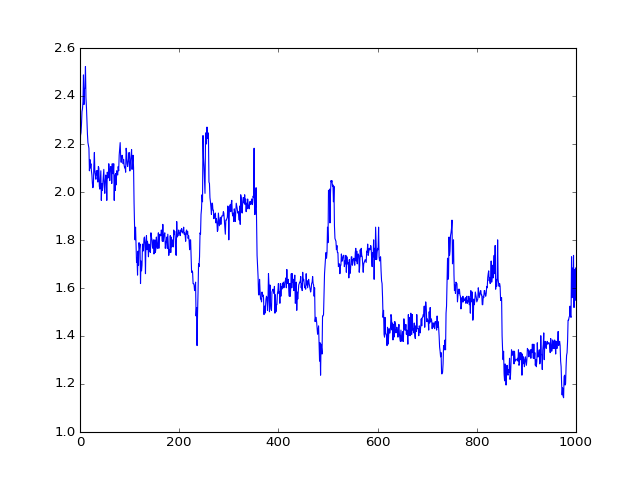

In [259]:
plt.plot(y[:1000])

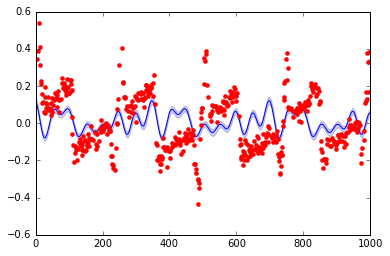

5459.46926755


In [256]:
plt.plot(t[:Ns],y_model[:Ns],'b',label='predicted mean')
plt.fill_between(t[:Ns],y_model[:Ns]-2*std_dev[:Ns], y_model[:Ns]+2*std_dev[:Ns], facecolor='blue', alpha=0.2)
plt.plot(t_obs,y[i_obs]-y_trend[i_obs],'r.',ms=8,label='observations')
#plt.plot(y_model)
#plt.plot(y[:500]-y_trend[:500])
plt.show()
print(like_Per([sigma_y_GP_test, gamma_test, sigma_test, per_test], y_obs, t_obs))

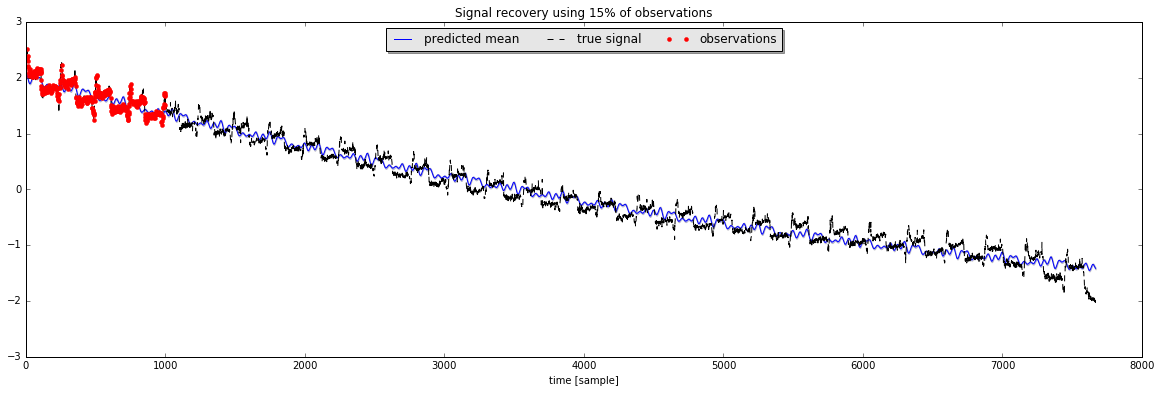

In [246]:
#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model_trend,'b',label='predicted mean')
plt.fill_between(t,y_model_trend-2*std_dev-2*sigma_y_GP_test, y_model_trend+2*std_dev+2*sigma_y_GP_test, facecolor='blue', alpha=0.2)
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_trend_comp,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE.eps",format='eps', dpi=1000)

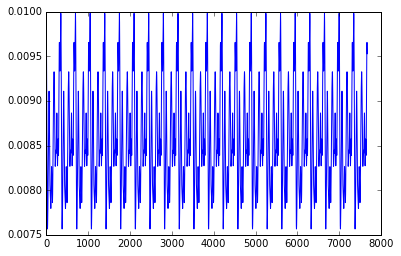

In [247]:
plt.plot(t,std_dev)

In [248]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_Per=0
params0=np.asarray([sigma_y_GP_test,  gamma_test,  sigma_test, per_test])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
#minimize(J,x0[i],args=(y),method=method,jac=jac)
opt = {'disp':1,'maxiter':50}
#res=minimize(like_Per,X0, args=args,method='L-BFGS-B',jac=like_Per_Df,tol=0.00000001/(2.22E-12),options=opt)
res=minimize(like_Per,X0, args=args,method='L-BFGS-B',jac=like_Per_Df,options=opt)
#res=minimize(like_Per,X0, args=args,method='Nelder-Mead',jac=False,tol=0.00000001/(2.22E-12),options=opt)
time_GP=time.time()-time_GP
time_Per = time_GP
sigma_y_GP_test, gamma_test, sigma_test, per_test = np.exp(res.x)
print('Hiperparametros encontrados: ', np.exp(res.x), 'NLL: ', res.fun)
print('Tiempo transcurrido %f' %time_Per)

('Condicion inicial optimizador: ', array([  1.00000000e+01,   3.00000000e+00,   3.00000000e-01,
         3.50000000e+02]))
('Hiperparametros encontrados: ', array([  1.48605163e-01,   3.00000000e+00,   2.99035279e-01,
         3.48874492e+02]), 'NLL: ', -227.42114619329664)
Tiempo transcurrido 55.308669


In [249]:
print(sigma_y_GP_test,gamma_test,sigma_test,per_test)

(0.14860516273437485, 3.0000000000000004, 0.29903527899797977, 348.87449216430957)


In [250]:
cov=Per_diag(t,t,gamma=gamma_test,sigma=sigma_test,per=per_test)
cov_obs=Per(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
K_star=Per(t,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
Gram = cov_obs+sigma_y_GP_test**2*np.identity(N_obs)
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)


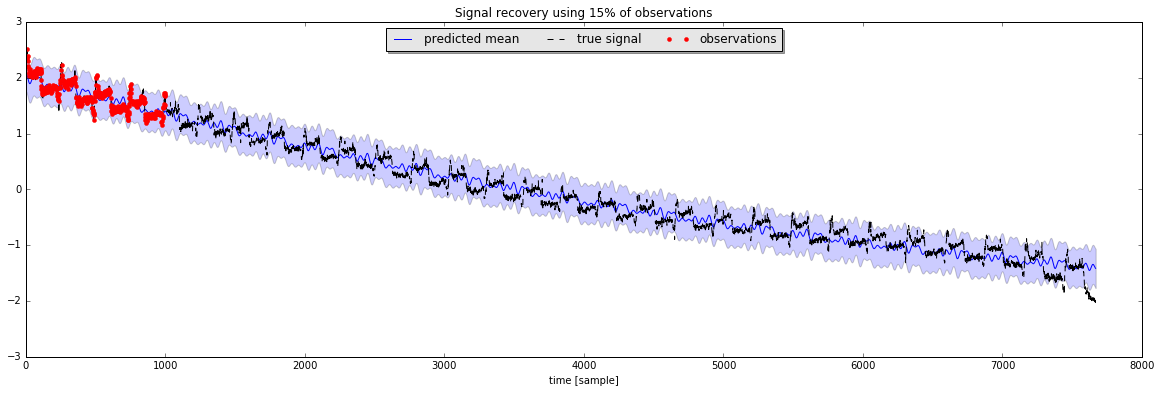

In [251]:

#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model_trend,'b',label='predicted mean')
plt.fill_between(t,y_model_trend-2*std_dev-2*sigma_y_GP_test, y_model_trend+2*std_dev+2*sigma_y_GP_test, facecolor='blue', alpha=0.2)
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_trend_comp,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("PER_post.eps",format='eps', dpi=1000)